In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [2]:
data = Path.cwd() / 'data'
ch2 = data / 'dataset_2'
cc2_file = ch2 / 'creditcard_sampledata_2.csv'

In [3]:
df2 = pd.read_csv(cc2_file)
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [4]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y
X, y = prep_data(df2)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (7300, 28)
y shape: (7300,)


In [5]:
X[0, :]

array([ 4.28408570e-01,  1.64002800e+00, -1.84885886e+00, -8.70902974e-01,
       -2.04848888e-01, -3.85675453e-01,  3.52792552e-01, -1.09830131e+00,
       -3.34596757e-01, -6.79088729e-01, -3.96709268e-02,  1.37266082e+00,
       -7.32000706e-01, -3.44528134e-01,  1.02475103e+00,  3.80208554e-01,
       -1.08734881e+00,  3.64507163e-01,  5.19236276e-02,  5.07173439e-01,
        1.29256539e+00, -4.67752261e-01,  1.24488683e+00,  6.97706854e-01,
        5.93750372e-02, -3.19964326e-01, -1.74444289e-02,  2.74400000e+01])

In [6]:
df2.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [7]:
# Count the total number of observations from the length of y
total_obs = len(y)
total_obs

7300

In [8]:
# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

7000

In [9]:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

95.89%


Random Forest Classifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = RandomForestClassifier(random_state=5, n_estimators=20)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.991


Perfomance evaluation

In [11]:
# Predict probabilities
probs = model.predict_proba(X_test)
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


Plotting the Precision vs. Recall Curve

In [12]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7890250388880526

In [13]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


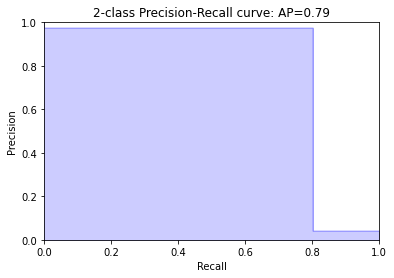

In [14]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

Hyperparameter tuning

In [15]:
# GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid 
param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Define which model to use
model = RandomForestRegressor()
# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, 
                                 param_grid = param_grid, 
                                 cv = 5,
                                 n_jobs = -1, 
                                 scoring='f1')

In [16]:
# Fit the grid search to the data
grid_search_model.fit(X_train, y_train)

# Get the optimal parameters 
grid_search_model.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

# Get the best_estimator results
grid_search.best_estimator_
grid_search.best_score_

KeyboardInterrupt: 

Model adjustments

In [ ]:
#Adjust the random forest model to deal with highly imbalanced fraud data, is to use the class_weights option.
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5, n_estimators=100)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

In [ ]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [ ]:
# Change the model options
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10, 
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)


In [ ]:
Parameter optimization with GridSearchCV
For fraud detection we are mostly interested in catching as many fraud cases as possible
-> get the best possible Recall score

In [ ]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

In [ ]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

In [ ]:
#2.4